In [1]:
%pylab inline
from scipy import interpolate
from scipy import optimize

Populating the interactive namespace from numpy and matplotlib


In [2]:
e = 1  # onsite energy
t = 1 # hopping
U = 15 # coulob repulsion
ne = 1.4 # number of electrons per unit cell/ occupation number
T = 1 # tempreture
delta=0.1

sigma=0.02
# The occupation number independent part of the Hamiltonina
nk = 200
kran = linspace(-pi,pi,nk,endpoint=False)
kx,ky = meshgrid(kran,kran)
kx = kx.flatten()
ky = ky.flatten()
gamma = -(1+exp(-1j*2*kx)+exp(-1j*(kx-ky))+exp(-1j*(kx+ky)))
H0k = zeros((len(gamma),2,2),dtype=complex)
H0k[:,0,1] = gamma
H0k[:,1,0] = conj(gamma)

In [3]:
# this generates eigen values and eigen vectors and returns them 
def make_spectr(U,n1,n2):
    Hk = H0k.copy()
    Hk[:,0,0] = U*n1
    Hk[:,1,1] = U*n2
    return eigh(Hk)

In [4]:
def densty(E,sigma=0.02):
    return sum(1/(sigma*sqrt(2*pi))*exp(-((E-hamiltonian(U,n1,n2)[0].flatten())/sigma)**2/2))

In [5]:
def get_chemical_pot(ne): # ne: number of electrons per unit cell
    NE,eran,_=hist(hamiltonian(U,n1,n2)[0].flatten(),linspace(-6,6,200),cumulative=True,density=True)
    mu= interp1d(NE,eran[:-1])
    return mu(ne)

In [6]:
def num_of_electron_MKII(mu,site,kbt=0.01,use_Fermi=False):
    if use_Fermi:
        avg_num_of_elec = (\
        sum(abs(vects[:,site,0])**2*fermi(vals[:,0]-mu,kbt=kbt))+\
        sum(abs(vects[:,site,1])**2*fermi(vals[:,1]-mu,kbt=kbt)))/num_of_eigen_val
    else:
        avg_num_of_elec = \
        (sum(abs(vects[vals[:,0]<mu,site,0])**2)+\
         sum(abs(vects[vals[:,1]<mu,site,1])**2))/num_of_eigen_val # len hamiltonian 0]
    return avg_num_of_elec

In [7]:
# a function that would find the new occupation number for each site, it needs to be run in a self consistency loop, this vergion can be used with while loop    
        
def self_consistency(n1_do,n2_do,n1_up,n2_up):
       

        vals_up,vects_up = make_spectr(U,n1_up,n2_up)
        vals_do,vects_do = make_spectr(U,n1_do,n2_do)
        
        # FIX THE STUF DOWN FROM HERE
        num_of_eigen_val = len(vals_up)
        
        #NE_up,eran_up,_= hist(vals_up.flatten(),linspace(-6,6,200),cumulative=True,density=True)
        #mu_up = interp1d(NE_up,eran_up[:-1],fill_value="extrapolate")
        
        #NE_do,eran_do,_= hist(vals_do.flatten(),linspace(-6,6,200),cumulative=True,density=True)
        #mu_do = interp1d(NE_do,eran_up[:-1],fill_value="extrapolate")
        
        NE,eran,_= hist(array([vals_up,vals_do]).flatten(),linspace(-6,6,200),cumulative=True,density=True)
        mu = interpolate.interp1d(NE,eran[:-1],fill_value="extrapolate")
        
        n1_do_new = sum(abs(vects_do[vals_do[:,0]<mu(ne),0,0])**2)/num_of_eigen_val
        n2_do_new = sum(abs(vects_do[vals_do[:,1]<mu(ne),1,1])**2)/num_of_eigen_val
        n1_up_new = sum(abs(vects_up[vals_up[:,1]<mu(ne),0,1])**2)/num_of_eigen_val
        n2_up_new = sum(abs(vects_up[vals_up[:,1]<mu(ne),1,0])**2)/num_of_eigen_val
        
        

        # this is a comment
       
        return n1_do_new ,n2_do_new, n1_up_new, n2_up_new  # it should return the new n's
    

In [8]:

# a function that would find the new occupation number for each site, it needs to be run in a self consistency loop, this vergion can be used with fixed point f'n     
def self_consistency2(ns):
        n1_do,n2_do,n1_up,n2_up = ns  

        vals_up,vects_up = make_spectr(U,n1_do,n2_do)
        vals_do,vects_do = make_spectr(U,n1_up,n2_up)
        
        # FIX THE STUF DOWN FROM HERE
        num_of_eigen_val = len(vals_up)
        
        #NE_up,eran_up,_= hist(vals_up.flatten(),linspace(-6,6,200),cumulative=True,density=True)
        #mu_up = interp1d(NE_up,eran_up[:-1],fill_value="extrapolate")
        
        #NE_do,eran_do,_= hist(vals_do.flatten(),linspace(-6,6,200),cumulative=True,density=True)
        #mu_do = interp1d(NE_do,eran_up[:-1],fill_value="extrapolate")
        
        NE,eran,_= hist(array([vals_up,vals_do]).flatten(),linspace(-6,6,200),cumulative=True,density=True)
        mu = interpolate.interp1d(NE,eran[:-1],fill_value="extrapolate")
        
        n1_do_new = sum(abs(vects_do[vals_do[:,0]<mu(ne),0,0])**2)/num_of_eigen_val
        
        n1up_new = (sum(abs(vecs_up[:,0,0])**2*fFD(vals_up[:,0]-mu,kbt))
               +sum(abs(vecs_up[:,0,1])**2*fFD(vals_up[:,1]-mu,kbt)))/nk**2
        
        
        n2_do_new = sum(abs(vects_do[vals_do[:,1]<mu(ne),1,1])**2)/num_of_eigen_val
        n1_up_new = sum(abs(vects_up[vals_up[:,1]<mu(ne),0,1])**2)/num_of_eigen_val
        n2_up_new = sum(abs(vects_up[vals_up[:,1]<mu(ne),1,0])**2)/num_of_eigen_val  ## you should normlize themm all to be
        
        ns_new = array([n1_do_new ,n2_do_new, n1_up_new, n2_up_new])
        ns_new = (ns_new * ne)/ sum(ns_new)
        
        

        # this is a comment
       
        return array([n1_do_new ,n2_do_new, n1_up_new, n2_up_new]) - ns

/home/assem/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


0:  |F(x)| = 0.48603; step 1
1:  |F(x)| = 0.322164; step 1
2:  |F(x)| = 0.296053; step 0.0690143
3:  |F(x)| = 0.225426; step 0.473131
4:  |F(x)| = 0.147811; step 1
5:  |F(x)| = 0.105061; step 1
6:  |F(x)| = 0.0862594; step 0.275541
7:  |F(x)| = 0.0805731; step 0.0625134
8:  |F(x)| = 0.286354; step 1


/home/assem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


9:  |F(x)| = 0.266222; step 0.0236947
10:  |F(x)| = 0.0367535; step 0.269217
11:  |F(x)| = 0.0229487; step 1
12:  |F(x)| = 0.00958503; step 0.0596793
13:  |F(x)| = 0.00955995; step 0.00411879
14:  |F(x)| = 0.0095589; step 6.97231e-05
15:  |F(x)| = 0.00955787; step 0.000167232
16:  |F(x)| = 0.00954724; step 0.00112417
17:  |F(x)| = 0.125985; step 1
18:  |F(x)| = 0.012277; step 1
19:  |F(x)| = 0.225488; step 1
20:  |F(x)| = 0.0138422; step 1
21:  |F(x)| = 0.0197307; step 1
22:  |F(x)| = 0.00989242; step 1
23:  |F(x)| = 0.00943106; step 0.325099
24:  |F(x)| = 0.00942242; step 0.00106979
25:  |F(x)| = 0.00941353; step 0.00103776
26:  |F(x)| = 0.229921; step 1
27:  |F(x)| = 0.0245313; step 1
28:  |F(x)| = 0.0157453; step 0.416636
29:  |F(x)| = 0.0118389; step 1
30:  |F(x)| = 0.00934201; step 1
31:  |F(x)| = 0.00308495; step 1
32:  |F(x)| = 0.00308486; step 0.000119597
33:  |F(x)| = 0.00262948; step 1
34:  |F(x)| = 0.00261087; step 0.000307178
35:  |F(x)| = 0.0144531; step 1
36:  |F(x)| = 0.

KeyboardInterrupt: 

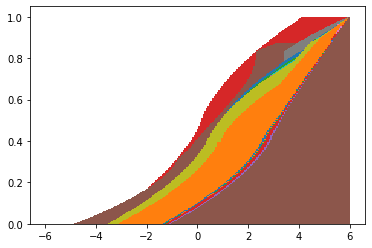

In [9]:
n1_up = (ne/4) + delta #occupation on site 1
n1_do = (ne/4) - delta
n2_up = (ne/4) + delta
n2_do = (ne/4) - delta
optimize.root(self_consistency2, x0=[n1_up,n2_up, n1_do,n2_do ],method='broyden1',options={'disp':True})

In [9]:
# n1_up = (ne/4) + delta # intial values of occupation on sites
# n1_do = (ne/4) - delta
# n2_up = (ne/4) + delta
# n2_do = (ne/4) - delta
# discrepancy = 10
# while discrepancy >= 10**-5:  # while loop to find the self consistant ocuupation numbers
    
#     n1_do_new ,n2_do_new, n1_up_new, n2_up_new  = self_consistency(n1_do,n2_do,n1_up,n2_up)
    
#     discrepancy = sqrt((n1_up_new-n1_up)**2+
#                            (n2_up_new-n2_up)**2+
#                            (n1_do_new-n1_do)**2+
#                            (n2_do_new-n2_do)**2)
#     n1_up,n2_up, n1_do,n2_do = n1_up_new,n2_up_new ,n1_do_new,n2_do_new
#     print(discrepancy)


    
    
    

In [ ]:
n1_up = (ne/4) + delta #occupation on site 1
n1_do = (ne/4) - delta
n2_up = (ne/4) + delta
n2_do = (ne/4) - delta

optimize.fixed_point(self_consistency2,[n1_up,n2_up, n1_do,n2_do ],maxiter = 1000)   # another method using fixed point function to find the self consistant solution


In [14]:
# def total_energy (U,ne):  # i'm a bit confused on how to find the total energy
#     discrepancy = 10

#     n1_up,n2_up = ne/4+delta,ne/4-delta
#     #n1_do,n2_do = ne/2-delta,ne/2+delta #AFM
#     n1_do,n2_do = ne/4+delta,ne/4-delta  #FM
#     vals_up, vects_up, vals_do, vects_do = self_consistency(U,n1_do,n2_do,n1_up,n2_up)

#     return(total_energy)

In [17]:
#class HubbardModel():
    
 #   def __init__(self,on_site_energy,coulomb_repulsion,number_of_electrons_per_unit_cell):
        
  #      self.on_site_energy=on_site_energy
   #     self.coulomb_repulsion=coulomb_repulsion
    #    self.number_of_electrons_per_unit_cell
    

In [ ]:
n1up_new = (sum(abs(vecs_up[:,0,0])**2*fFD(vals_up[:,0]-mu,kbt))
               +sum(abs(vecs_up[:,0,1])**2*fFD(vals_up[:,1]-mu,kbt)))/nk**2